TASK 2: Image Deblurring Using U-Net architecture

Objective: The objective of this task is to develop a deep learning model to perform image deblurring and denoising using the UNet architecture. The provided dataset consists of triplets of images for each scene: sharp, defocused-blurred, and motion-blurred images. The model should be capable of taking a blurred image as input and generating a high-quality, sharp, and noise-free image as output.

PS: The performance of the model will be evaluated based on the L2 norm distance between the predicted sharp image and the ground truth sharp image on both the training and test sets. Build and train a UNet-based model to deblur and denoise the defocused-blurred and motion-blurred images, aiming to restore them to their corresponding sharp versions. Submission should be only in PyTorch framework.

Deadline: As the secy tasks have been released, deadline for this task is 25th May EOD.

Link To the Dataset: https://www.kaggle.com/datasets/kwentar/blur-dataset

Understanding UNet: https://paperswithcode.com/method/u-net

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torchvision import models
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
    print(device)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')
mps


In [4]:
def create_subdir(dir,index):
    destination_path = f"{dir}/../../{dir}_test"
    os.makedirs(destination_path, exist_ok=False)
    subdir=sorted(os.listdir(dir))[:index]
    for i in range(len(subdir)):
        shutil.move(dir + '/' + subdir[i],f"{destination_path}/{subdir[i]}")

In [5]:
data="data"
motion_blurred = data + "/motion_blurred"
defocused_blurred = data + "/defocused_blurred"
sharp = data + "/sharp"

In [ ]:
#Implementing 80:20 train-test split

length=len(os.listdir(motion_blurred))
split_index=int(4/5*length)

print(length, split_index)

In [ ]:
create_subdir(motion_blurred,split_index)
create_subdir(defocused_blurred,split_index)
create_subdir(sharp,split_index)

os.rename(motion_blurred,motion_blurred + "_train")
os.rename(sharp,sharp+"_train")
os.rename(defocused_blurred,defocused_blurred + "_train")

In [7]:
batch_size = 8
image_size= 256
model_path="UNet_new.pth"
epochs=10

In [8]:
class ImageDataset(Dataset):
    def __init__(self,root_path,train=True):
        data=root_path
        if train:
            self.images=sorted(f"data/motion_blurred_train/{i}" for i in os.listdir(data + "/motion_blurred_train"))
            self.masks=sorted(f"data/sharp_train/{i}" for i in os.listdir(data + "/sharp_train"))
        else:
            self.images=sorted(f"data/motion_blurred_test/{i}" for i in os.listdir(data + "/motion_blurred_test"))
            self.masks=sorted(f"data/sharp_test/{i}" for i in os.listdir(data + "/sharp_test"))

        self.transform=T.Compose([
            T.Resize((128,256)),
            T.ToTensor()
        ])
    def __getitem__(self,idx):
        img=Image.open(self.images[idx]).convert("RGB")
        mask=Image.open(self.masks[idx]).convert("RGB")
        return(self.transform(img),self.transform(mask))
    def __len__(self):
        return len(self.images)
        

In [9]:
train_dataset=ImageDataset("data")
test_dataset=ImageDataset("data",train=False)

print(len(train_dataset))
print(len(test_dataset))

280
70


In [10]:
train_dataloader=DataLoader(dataset=train_dataset,shuffle=True,batch_size=batch_size)
test_dataloader=DataLoader(dataset=test_dataset,shuffle=True,batch_size=batch_size)

In [27]:
sample_dir = "UNet_Generated"
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index,images,model,show=True):
    masks = model(images)
    mask_fname = 'generated-masks-{0:0=4d}.png'.format(index)
    save_image(masks, os.path.join(sample_dir, mask_fname), nrow=8)
    print('Saving', mask_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(masks.cpu().detach(), nrow=8).permute(1, 2, 0))

In [11]:
def show_batch(image_batch, title):
    plt.figure(figsize=(20,16))
    grid = make_grid(image_batch, nrow=8)
    plt.imshow(grid.cpu().detach().numpy().transpose(1,2,0))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) 

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) 

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) 
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) 
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)  

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) 
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) 
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2) 

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) 
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [17]:
model = UNet().to(device)
criterion = nn.MSELoss()                                    #L2 Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

 10%|█         | 1/10 [01:33<14:04, 93.87s/it]

Epoch [1/10], Train Loss: 1.6395, Val Loss: 0.9711


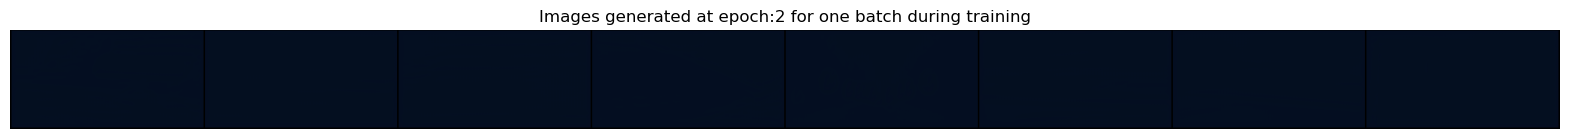

 20%|██        | 2/10 [03:07<12:28, 93.62s/it]

Epoch [2/10], Train Loss: 0.8763, Val Loss: 0.7387


 30%|███       | 3/10 [04:40<10:54, 93.47s/it]

Epoch [3/10], Train Loss: 0.0974, Val Loss: 0.1909


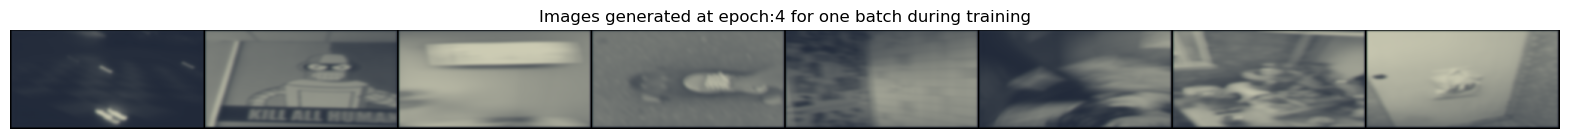

 40%|████      | 4/10 [06:16<09:25, 94.31s/it]

Epoch [4/10], Train Loss: 0.0452, Val Loss: 0.1724


 50%|█████     | 5/10 [07:49<07:49, 93.80s/it]

Epoch [5/10], Train Loss: 0.0445, Val Loss: 0.1716


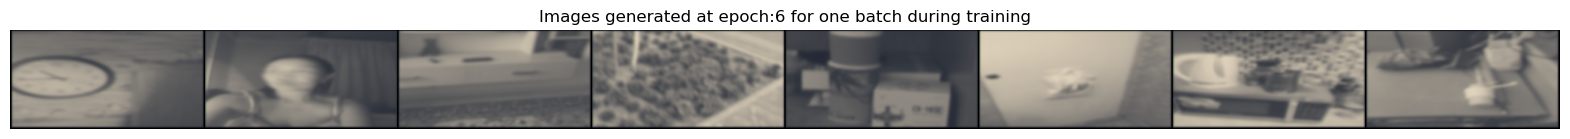

 60%|██████    | 6/10 [09:24<06:17, 94.29s/it]

Epoch [6/10], Train Loss: 0.0442, Val Loss: 0.1731


 70%|███████   | 7/10 [10:56<04:40, 93.57s/it]

Epoch [7/10], Train Loss: 0.0437, Val Loss: 0.1686


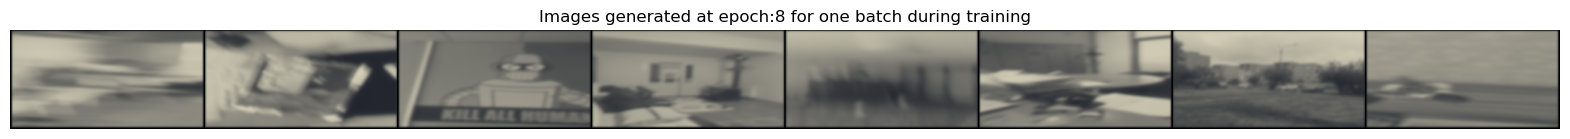

 80%|████████  | 8/10 [12:28<03:06, 93.23s/it]

Epoch [8/10], Train Loss: 0.0435, Val Loss: 0.1687


 90%|█████████ | 9/10 [14:00<01:32, 92.85s/it]

Epoch [9/10], Train Loss: 0.0435, Val Loss: 0.1676


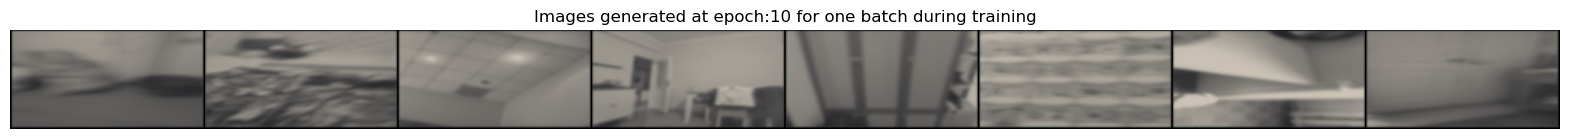

100%|██████████| 10/10 [15:33<00:00, 93.30s/it]

Epoch [10/10], Train Loss: 0.0432, Val Loss: 0.1673


In [18]:
metrics=[[],[]]

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    for idx,pair in enumerate(train_dataloader):
        images=pair[0].to(device)
        masks=pair[1].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        #print(f"{idx+1}/9 done ...")
        if (epoch+1)%2==0 and idx==20:
           show_batch(outputs,f"Images generated at epoch:{epoch+1} for one batch during training")

    train_loss /= len(train_dataloader)
    metrics[0].append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for idx,pair in enumerate(train_dataloader):
            images=pair[0].to(device)
            masks=pair[1].to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            #print(f"{idx+1}/9 done ...")

    val_loss /= len(test_dataloader)
    metrics[1].append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [22]:
torch.save(model.state_dict(),model_path)

Text(0.5, 1.0, 'Losses')

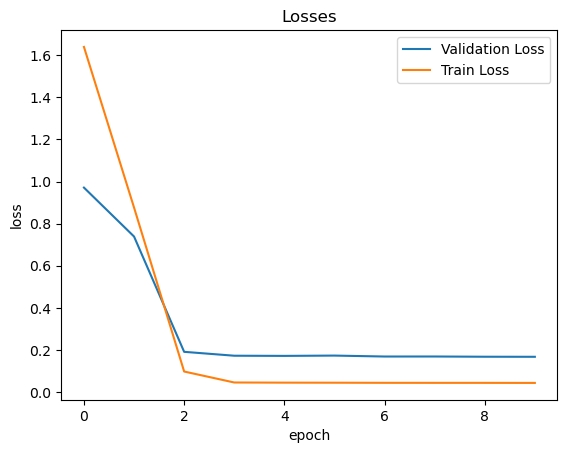

In [21]:
plt.plot(metrics[1], '-')
plt.plot(metrics[0], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Validation Loss', 'Train Loss'])
plt.title('Losses')

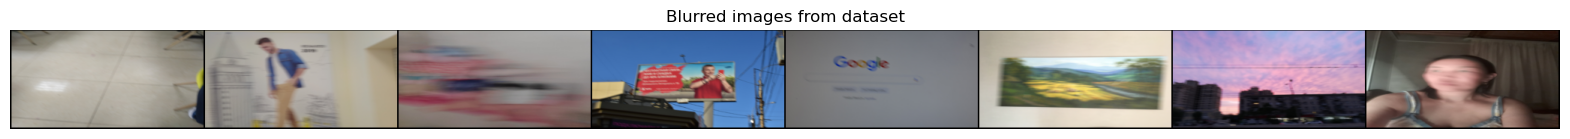

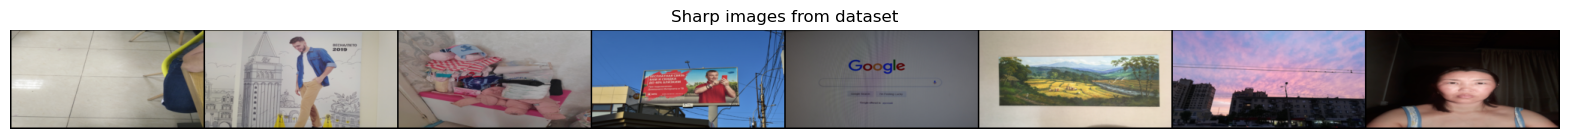

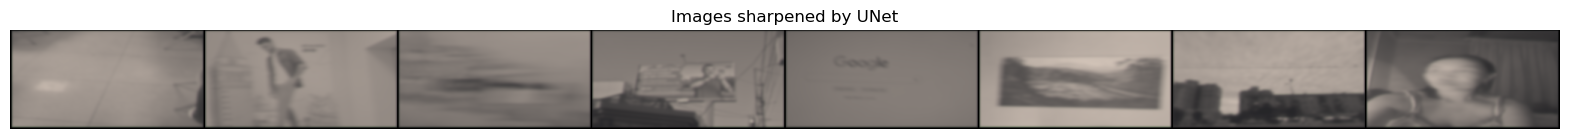

In [22]:
data_iter=iter(train_dataloader)
first_batch=next(data_iter)
images,masks=first_batch
outputs=model(images.to(device))
show_batch(images.to(device),"Blurred images from dataset")
show_batch(masks.to(device),"Sharp images from dataset")
show_batch(outputs.to(device),"Images sharpened by UNet")